# Introduction.
Over the years of looking at Spotify's own analysis for my preferences in their yearly "Wrapped", I have realized that I tend to play the same songs for a small period of time and despise the shuffle option. Shuffling makes it so that I listen to a variety of genres one after the other causing a bit of strain on my ears. Music can create a whole new environment for me and if I happen to be in a happy mood and hear a sad song or listen to rap and then country, my mood goes a little sour. Thus, I decided to create analyze my own data to see what my preferences are and to create a playlist with my favorite songs ordered by the most optimal musical flow. 

# Objective. 
---discuss optimal flow---

## 1. Importing the required libraries for this EDA.


In [180]:
import base64
import requests
import spotipy
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

## 2. Constant variables.
Here we have our variables needed throughout the EDA. We have the credentials which are then formated and encoded and then user_id as well as playlist ID from our "Top 100 of 2020".

In [3]:
client_id = 'ebc5cc312a104c888496063f8213e69b'
client_secret = 'ccadb15533184c5cab6915cca7da5a95'

client_creds = f'{client_id}:{client_secret}'
client_creds_b64 = base64.b64encode(client_creds.encode()) #encode it to bytes to pass through header

user_id = 'kontourkelly'
playlist_id = '37i9dQZF1EM5YUAAnrZexY'

## 3. Get spotify token for requests.
This step is to use Spotipy's endpoint and headers to request a token for other requests that we will ask for. 

In [5]:
# Grab a token for future requests
token_url = 'https://accounts.spotify.com/api/token'
token_data = {
    'grant_type': 'client_credentials'
}
token_headers = {
    'Authorization': f'Basic {client_creds_b64.decode()}' # decode byte str
}

# Extracting token data to actually get access token
r = requests.post(token_url, data=token_data, headers=token_headers)
data = r.json()
access_token = data['access_token']

## 4. Access token.
In the previous step we obtained the access token and every time the token expires, we need to reload step 3 and 4. This step is to get access to Spotipy.

In [6]:
# Access token
sp = spotipy.Spotify(auth = access_token)

## 5. Get the audio features.
Before we begin our analysis, we must first gather the data. In order to do so, we create a function to get the audio features of our desired playlist, in this case we will supply the function with our "Top 100 2020" songs. 


In [7]:
# Gets the song's audio feature based on track ids
def getPlaylistAudioFeatures(user_id, playlist_id, sp):
    songs = []
    ids = []

    # Based on Spotipy's documentation
    content = sp.user_playlist_tracks(user_id, playlist_id)
    songs += content['items']
              
    # Getting the track ids
    for i in songs:
        ids.append(i['track']['id'])
        
    # Getting the audio feature of each song in json
    index = 0
    audio_features = []
    while index < len(ids):
        # Based on Spotiypy's documentation
        audio_features += sp.audio_features(ids[index:index + 50])
        index += 50
    
    # Formatting
    features_list = []
    for features in audio_features:
        features_list.append([features['energy'], features['liveness'],
                              features['tempo'], features['speechiness'],
                              features['acousticness'], features['instrumentalness'],
                              features['time_signature'], features['danceability'],
                              features['key'], features['duration_ms'],
                              features['loudness'], features['valence'],
                              features['mode'], features['type'],
                              features['uri']])

    # Making the list into a dataframe
    df = pd.DataFrame(features_list, columns = ['energy', 'liveness',
                                                'tempo', 'speechiness',
                                                'acousticness', 'instrumentalness',
                                                'time_signature', 'danceability',
                                                'key', 'duration_ms', 'loudness',
                                                'valence', 'mode', 'type', 'uri'])
    # Export to CSV to merge for future use.
    df.to_csv(f'{user_id}-{playlist_id}.csv', index=False)
    return df

audioF = getPlaylistAudioFeatures(user_id, playlist_id, sp)
print(audioF)

    energy  liveness    tempo  speechiness  acousticness  instrumentalness  \
0    0.457    0.1100  175.659       0.0691        0.2240          0.000083   
1    0.410    0.5170  127.963       0.0612        0.6870          0.000083   
2    0.345    0.1070  101.928       0.0560        0.3830          0.000000   
3    0.252    0.1400  169.459       0.0927        0.9240          0.000000   
4    0.339    0.1030  119.606       0.0651        0.8530          0.000000   
..     ...       ...      ...          ...           ...               ...   
95   0.492    0.0995  115.989       0.0752        0.4310          0.089900   
96   0.568    0.1530   91.735       0.0495        0.6280          0.019600   
97   0.354    0.0682  179.433       0.2060        0.4290          0.000542   
98   0.837    0.3440  168.114       0.1150        0.0842          0.000000   
99   0.964    0.3260   94.558       0.0733        0.0139          0.000000   

    time_signature  danceability  key  duration_ms  loudness  v

## 6. Get the lists of tracks from the playlist.
Although we have the audio features, we do not know which values belong to which songs. Sure, it is unique by its Spotify uri, but that does not mean much to the naked eye. Here we will retrieve the track names to add to the csv we exported earlier. 

After exporting track names to a csv, reformat the cells such that there are no apostrophes and parantheses in our values; continue by separating artist name and song name to separate cells. 

First, replace all instances of "('" and "')" with nothing. By doing so, we notice that not all the songs were replaced and by looking further we notice that songs with apostrophes in the title use double quotes instead of single so replace the trailing "")" with nothing. Notice that we keep our commas because now we will use the text to column function to split the two. Now format the rest of the data by getting rid of the remaining apostrophes and copying the columns over the csv file containing audio features. 

In [60]:
def showTracks(user_id, playlist_id):
    content = sp.user_playlist_tracks(user_id, playlist_id)
    for i, item in enumerate(content['items']):
        track = item['track']
        print((track['artists'][0]['name'], track['name']))
    return

track_names = showTracks(user_id, playlist_id)
track_names.to_csv('tracknames.csv', index=False)

('H.E.R.', 'Wrong Places (from Songland)')
('Lucky Daye', 'Call')
('Tessie', 'Show Me You Love Me')
('JoJo', 'Joanna')
('Tessie', 'Love Me')
('UMI', 'Love Affair')
('Lucky Daye', 'Shoulda (feat. Babyface)')
('Crush', 'NAPPA 나빠')
('H.E.R.', 'Hold On')
('UMI', 'Down to Earth')
('Lucky Daye', 'Buying Time')
('Crush', 'woo ah')
('NCT DREAM', 'BOOM')
('Sylo Nozra', 'Meadows (feat. Leo Dessi)')
('Tobe Nwigwe', 'JOURNEY')
('Crush', 'Mayday (Feat. Joy)')
('Rex Orange County', 'Best Friend')
('MOON', 'Now')
('NCT 127', 'Elevator (127F)')
('Lucky Daye', 'Late Night')
('Hermitude', 'OneFourThree (feat. Buddy & BJ The Chicago Kid)')
('Sam Kim', 'Make Up')
('Alex Mali', 'No Limits')
('Kaash Paige', 'Love Songs - Remix')
('MOON', 'Day n Nite')
('Collard', 'Stone')
('Mei', 'Damn Mountains')
('Snoh Aalegra', 'Find Someone Like You')
('Johnny Stimson', 'Casual')
('Peach Tree Rascals', 'Mariposa')
('JoJo', 'In Your Room')
('Vedo', 'You Got It')
('Sylo Nozra', 'omw')
('MAX', 'Acid Dreams')
('Musiq Soulch

## 7. Getting genres of each song.

For this EDA, we also want to take a look at the genre of each song. Spotipy does not have an explicit function for this so we will start by getting each artist's ID then use Spotipy's artist function which we can index genre from. 

In [ ]:
# Get artist ID from each track 
def getArtistID(user_id, playlist_id):
    songs = []
    artist_ids = []
    content = sp.user_playlist_tracks(user_id, playlist_id)
    songs += content['items']
    # Similar method to getting track ID, but instead we get artist ID
    for i in songs:
        artist_ids.append(i['track']['artists'][0]['id'])
    return artist_ids

artist_ids = getArtistID(user_id, playlist_id)

# Get genre of each track.
def getGenre(artist_ids):
    ids = []
    for i in artist_ids:
        item = sp.artist(i) # Spotify's function
        ids.append(item['genres'])
    return pd.DataFrame(ids) # Make into a dataframe so we can export to csv. 
        
genres = getGenre(artist_ids)
genres.to_csv('genres.csv', index=False)

## 7. Import the data.
Now we begin our EDA by first importing our data the first of which is all the data we have complied so far, merged into one csv. 

In [414]:
df = pd.read_csv('/Users/kellylam/Downloads/kontourkelly-37i9dQZF1EM5YUAAnrZexY.csv')

## 8. Taking a peek at our data/ EDA.
We see two NaN values, specifically for the artist Tessie. I suspect this is because Tessie is a new artist with not many followers so it could be that she has yet to list her genre. There are other columns for genre as well, but we will utilize the first column for analysis instead. 


Spotify describes the audio features as such: 

* **Energy:**  Represents intensity and activity. Features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

* **Liveness:** Represents proability of whether or not the track was produced with a live audience. 

* **Tempo:** Beats per minute of the song.
 
* **Speechiness:** Detects the presence of spoken word. The higher the number, the more likely the track is to be similar to an audio book; the lesser the number, the more instrumental it is. 
 
* **Acousticness:** Represents the level of acousticness i.e. not much electronic sounds.

* **Instrumentalness:** Predicts the level of vocalness. No vocal content like rapping or singing will give it a score closer to 0.

* **Danceability:** Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

* **Key:** The musical key of the track. 0 = C, 1 = C♯/D♭, etc. 

* **Loudness:** The avgerage loudness of a track in decibels.

* **Valence:** The musical positiveness conveyed by a track. Tracks with high valence sound more happy and tracks with low valence are sad.

* **Mode:** Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

In [415]:
df.head(5)

,Song,Artist,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,...,type,uri,Genre,Column1,Column2,Column3,Column4,Column5,Column6,Column7
0,Wrong Places (from Songland),H.E.R.,0.457,0.110,175.659,0.0691,0.224,0.000083,4,0.548,...,audio_features,spotify:track:2mtLGVN6xZm93wDG9nvviS,alternative r&b,dance pop,pop,pop rap,r&b,urban contemporary,NaN,NaN
1,Call,Lucky Daye,0.410,0.517,127.963,0.0612,0.687,0.000083,4,0.777,...,audio_features,spotify:track:4tvw503IOIq9uc0QNYVey2,alternative r&b,indie r&b,indie soul,pop r&b,NaN,NaN,NaN,NaN
2,Show Me You Love Me,Tessie,0.345,0.107,101.928,0.0560,0.383,0.000000,3,0.932,...,audio_features,spotify:track:6zal6hGpmWksImLwLAKonU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Joanna,JoJo,0.252,0.140,169.459,0.0927,0.924,0.000000,4,0.445,...,audio_features,spotify:track:50MCdJc0nw3DMnzmIJkEwi,dance pop,hip pop,pop,pop dance,pop rap,post-teen pop,r&b,urban contemporary
4,Love Me,Tessie,0.339,0.103,119.606,0.0651,0.853,0.000000,3,0.668,...,audio_features,spotify:track:3wwqEwt6HQOhAEVK9xIWG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Let us also take a look at the data types we have. Seems like they have the data types they are supposed to, so no need to convert any columns to make values calculable. **

In [416]:
df.dtypes

Song                 object
Artist               object
energy              float64
liveness            float64
tempo               float64
speechiness         float64
acousticness        float64
instrumentalness    float64
time_signature        int64
danceability        float64
key                   int64
duration_ms           int64
loudness            float64
valence             float64
mode                  int64
type                 object
uri                  object
Genre                object
Column1              object
Column2              object
Column3              object
Column4              object
Column5              object
Column6              object
Column7              object
dtype: object

Let us drop the trailing genre columns, time signature, the duration of the song, and the uri; these will not be analyzed. Time signature represents the number of beats in a musical bar which is not helpful. Duration will similarly not be helpful for an optimal flow. Lastly, we no longer have need for the uri since we have the song name and artist and type is self explanatory.

In [417]:
df = df.drop(df.loc[:, 'Column1':'Column7'].columns, axis = 1) 
df = df.drop(['time_signature', 'duration_ms','type', 'uri'], axis = 1)
df.head()

,Song,Artist,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,key,loudness,valence,mode,Genre
0,Wrong Places (from Songland),H.E.R.,0.457,0.110,175.659,0.0691,0.224,0.000083,0.548,4,-7.626,0.4940,1,alternative r&b
1,Call,Lucky Daye,0.410,0.517,127.963,0.0612,0.687,0.000083,0.777,0,-6.533,0.5520,1,alternative r&b
2,Show Me You Love Me,Tessie,0.345,0.107,101.928,0.0560,0.383,0.000000,0.932,7,-10.856,0.4680,1,NaN
3,Joanna,JoJo,0.252,0.140,169.459,0.0927,0.924,0.000000,0.445,8,-10.139,0.3440,0,dance pop
4,Love Me,Tessie,0.339,0.103,119.606,0.0651,0.853,0.000000,0.668,2,-9.802,0.0681,1,NaN


**Now let us confirm that we have no missing rows and that we only have the two missing genres from artist Tessie. 
Duplicate values are fine for columns other than song. We could assume that there are no duplicate songs, but just in case let us check anyways.**

In [418]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Song              100 non-null    object 
 1   Artist            100 non-null    object 
 2   energy            100 non-null    float64
 3   liveness          100 non-null    float64
 4   tempo             100 non-null    float64
 5   speechiness       100 non-null    float64
 6   acousticness      100 non-null    float64
 7   instrumentalness  100 non-null    float64
 8   danceability      100 non-null    float64
 9   key               100 non-null    int64  
 10  loudness          100 non-null    float64
 11  valence           100 non-null    float64
 12  mode              100 non-null    int64  
 13  Genre             98 non-null     object 
dtypes: float64(9), int64(2), object(3)
memory usage: 11.1+ KB


In [104]:
# print('Total record:', df.shape[0])
# print('Missing values:')
# print(df.isnull().sum(axis = 0))

print('Duplicate songs:', df['Song'].duplicated().sum(axis = 0))

Duplicate songs: 0


**Replace the two nan values of genre to the categorical mode.**

In [419]:
genre_nan = df['Genre'].mode().values[0]
df['Genre'] = df['Genre'].replace(np.nan, genre_nan)

In [17]:
df.describe()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,key,loudness,valence,mode
count,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.537570,0.178298,112.747020,0.088657,0.371282,4.057053e-03,0.660020,5.090000,-7.405300,0.508881,0.590000
std,0.150584,0.112710,28.261074,0.055598,0.242939,2.169162e-02,0.139891,3.493414,2.296876,0.203263,0.494311
min,0.234000,0.044100,67.467000,0.026000,0.005860,0.000000e+00,0.341000,0.000000,-12.521000,0.068100,0.000000
25%,0.435500,0.105250,92.096750,0.050050,0.157250,0.000000e+00,0.566500,1.750000,-9.002000,0.352250,0.000000
50%,0.529000,0.139500,108.029000,0.073250,0.390500,5.750000e-07,0.682500,5.000000,-7.457000,0.491000,1.000000
75%,0.638750,0.223500,125.284750,0.104250,0.544500,7.497500e-05,0.759750,8.000000,-5.919750,0.651250,1.000000
max,0.964000,0.664000,180.216000,0.301000,0.924000,1.930000e-01,0.932000,11.000000,-1.159000,0.961000,1.000000


## Genre

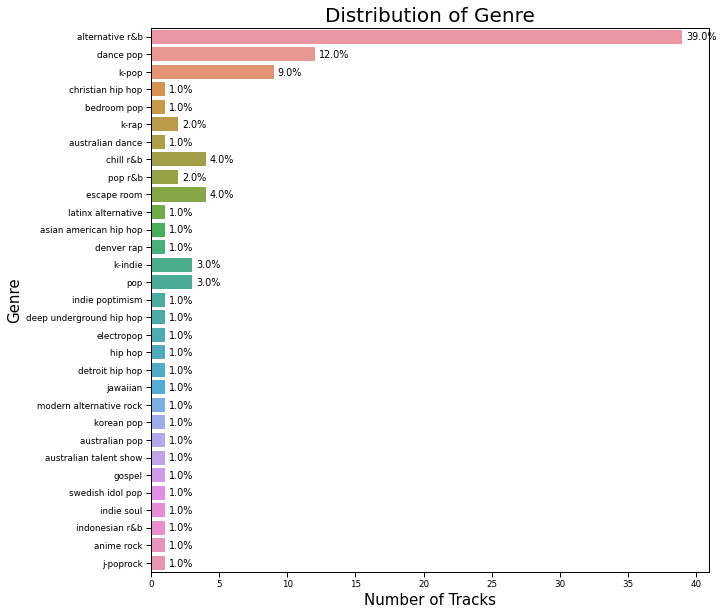

In [191]:
# Adjusting size of plot
plt.figure(figsize=(10, 10))

# Graphing the plot
ax = sns.countplot(y = 'Genre', data = df)
plt.title('Distribution of Genre', fontsize = 20)
plt.xlabel('Number of Tracks', fontsize = 15)
plt.ylabel('Genre', fontsize = 15)

# Showing percentages
total = len(df['Genre'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.3
        y = p.get_y() + p.get_height() - 0.2
        ax.annotate(percentage, (x, y))

plt.show()

## Number of artists in this playlist

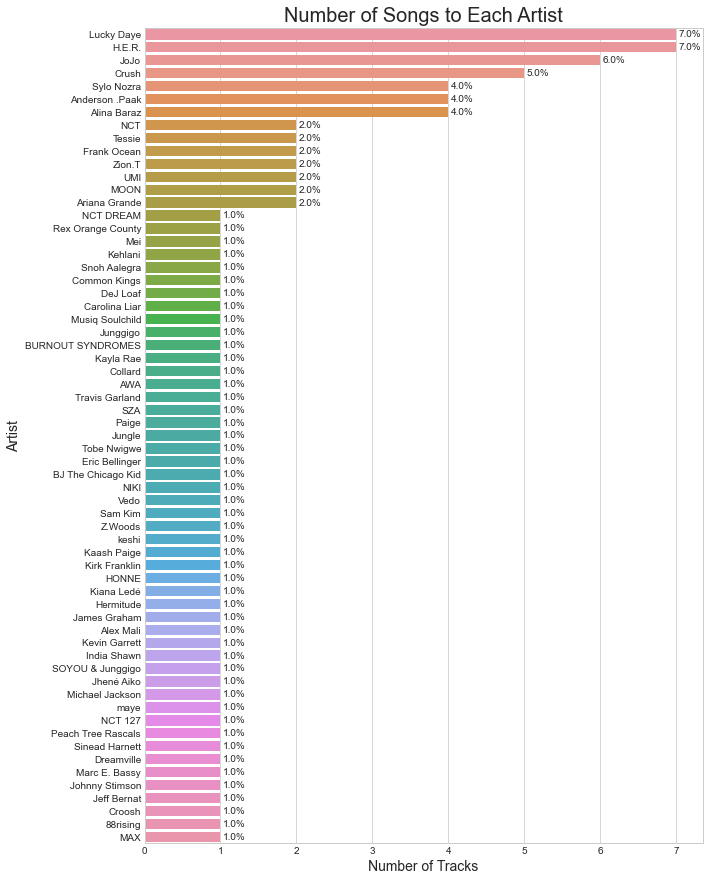

In [421]:
fig = plt.figure(figsize = (10,15))

ax = sns.countplot(y = 'Artist', data=df, order=df['Artist'].value_counts().index)
plt.title("Number of Songs to Each Artist", fontsize = 20)
plt.ylabel('Artist', fontsize = 14)
plt.xlabel('Number of Tracks', fontsize = 14)

total = len(df['Artist'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.03
        y = p.get_y() + p.get_height() - 0.2
        ax.annotate(percentage, (x, y))

plt.show()

## Key

/Users/kellylam/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9837 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/kellylam/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9837 missing from current font.
  font.set_text(s, 0, flags=flags)


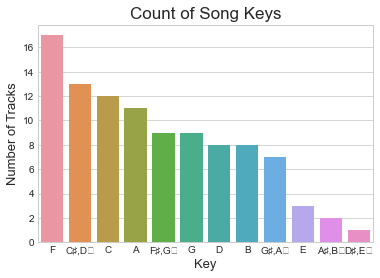

In [420]:
key_mapping = {0.0: 'C', 1.0: 'C♯,D♭', 2.0: 'D', 3.0: 'D♯,E♭', 4.0: 'E', 5.0: 'F', 6.0: 'F♯,G♭', 7.0: 'G', 8.0: 'G♯,A♭', 9.0: 'A', 10.0: 'A♯,B♭', 11.0: 'B'}
df['key'] = df['key'].map(key_mapping)

sns.countplot(x = 'key', data = df, order = df['key'].value_counts().index)
plt.title("Count of Song Keys", fontsize = 17)
plt.xlabel('Key', fontsize = 13)
plt.ylabel('Number of Tracks', fontsize = 13)
           
plt.show()

## Dancebility

Mean value for Danceability: 0.6600199999999998


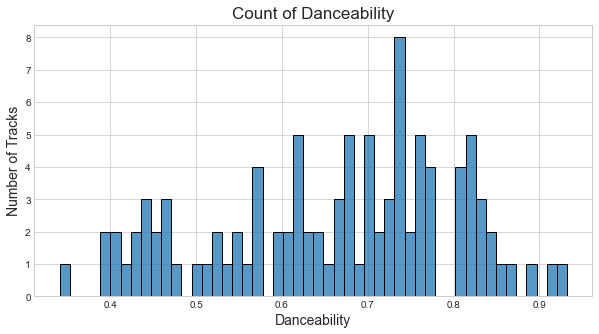

In [212]:
print("Mean value for Danceability:", df['danceability'].mean())

fig = plt.figure(figsize = (10,5))

sns.histplot(data = df, x = df['danceability'], bins = 50, palette = 'steelblue')
plt.title("Count of Danceability", fontsize = 17)
plt.xlabel('Danceability', fontsize = 14)
plt.ylabel('Number of Tracks', fontsize = 14)

plt.show()

## Energy

Mean value for energy: 0.5375700000000001


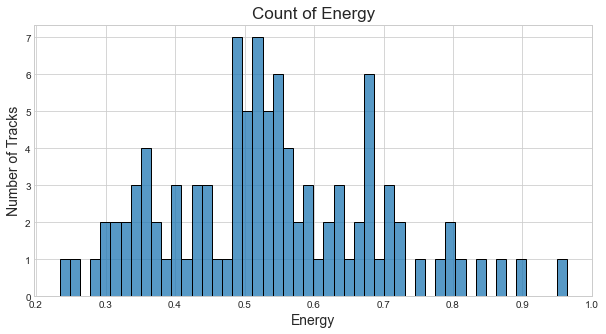

In [210]:
print("Mean value for energy:", df['energy'].mean())

fig = plt.figure(figsize = (10,5))

sns.histplot(data=df, x = df['energy'], bins = 50, palette = 'steelblue')
plt.title("Count of Energy", fontsize = 17)
plt.xlabel('Energy', fontsize = 14)
plt.ylabel('Number of Tracks', fontsize = 14)

plt.show()

## Tempo

Mean value for tempo: 112.74702


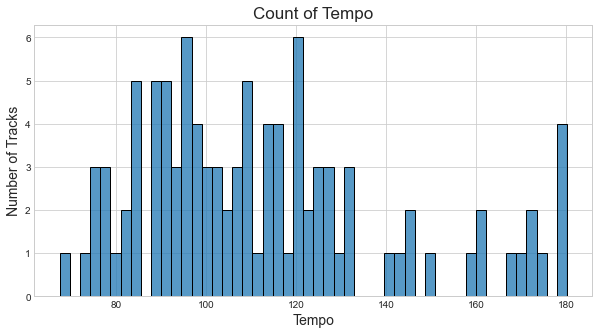

In [209]:
print("Mean value for tempo:", df['tempo'].mean())

fig = plt.figure(figsize = (10,5))

sns.histplot(data=df, x = df['tempo'], bins = 50, palette = 'steelblue')
plt.title("Count of Tempo", fontsize = 17)
plt.xlabel('Tempo', fontsize = 14)
plt.ylabel('Number of Tracks', fontsize = 14)

plt.show()

## Loudness

Mean value for loudness: -7.405299999999999


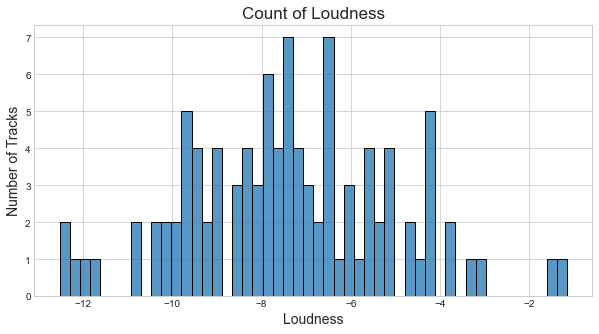

In [208]:
print("Mean value for loudness:", df['loudness'].mean())

fig = plt.figure(figsize = (10,5))

sns.histplot(data=df, x = df['loudness'], bins = 50, palette = 'steelblue')
plt.title("Count of Loudness", fontsize = 17)
plt.xlabel('Loudness', fontsize = 14)
plt.ylabel('Number of Tracks', fontsize = 14)

plt.show()

## Valence

Mean value for valence: 0.5088809999999997


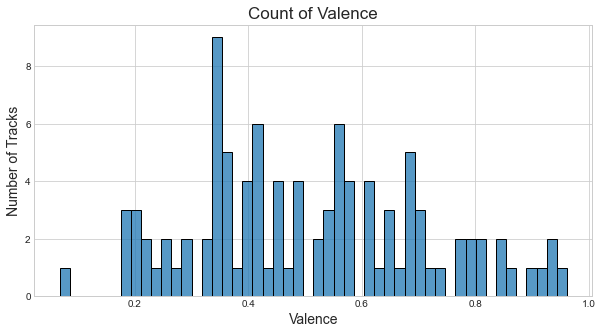

In [207]:
print("Mean value for valence:", df['valence'].mean())

fig = plt.figure(figsize = (10,5))

sns.histplot(data=df, x = df['valence'], bins = 50, palette = 'steelblue')
plt.title("Count of Valence", fontsize = 17)
plt.xlabel('Valence', fontsize = 14)
plt.ylabel('Number of Tracks', fontsize = 14)

plt.show()

## Instrumentalness

Mean value for instrumentalness: 0.018473989227005324


Text(0, 0.5, 'Number of Tracks')

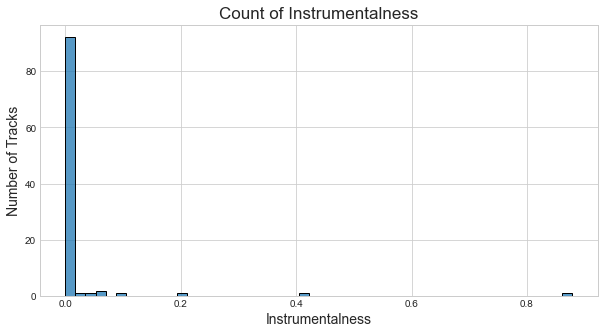

In [214]:
# Normalize instrumental column
x_array = np.array(df['instrumentalness'])
normalized_X = preprocessing.normalize([x_array])
df['instrumentalness'] = pd.Series(normalized_X.flatten())

print("Mean value for instrumentalness:", df['instrumentalness'].mean())

fig = plt.figure(figsize = (10,5))

sns.histplot(data=df, x = df['instrumentalness'], bins = 50, palette = 'steelblue')
plt.title("Count of Instrumentalness", fontsize = 17)
plt.xlabel('Instrumentalness', fontsize = 14)
plt.ylabel('Number of Tracks', fontsize = 14)

# plt.show()


## Mode

Mean value for mode: 0.59


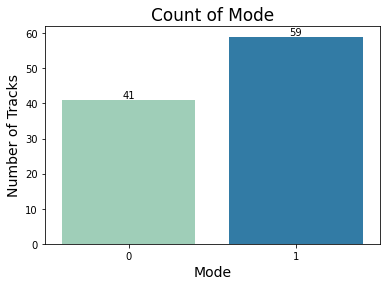

In [45]:
print("Mean value for mode:", df['mode'].mean())

ax = sns.countplot(x='mode', data=df, palette= 'YlGnBu')
plt.title("Count of Mode", fontsize = 17)
plt.xlabel('Mode', fontsize = 14)
plt.ylabel('Number of Tracks', fontsize = 14)

total = len(df['mode'])
for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        height = p.get_height()
        ax.text(x, height + 0.4, height, ha = 'center')
        
plt.show()

## Heatmap of audio feature

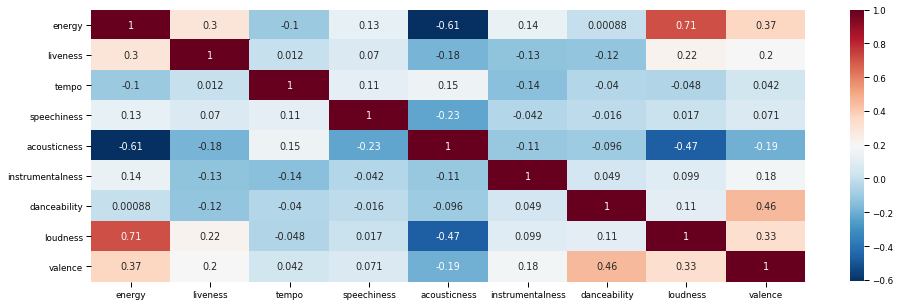

In [130]:
plt.figure(figsize = (16,5))
sns.heatmap(df.corr(), cmap="RdBu_r", annot=True)
plt.show()

## Energy and loudness

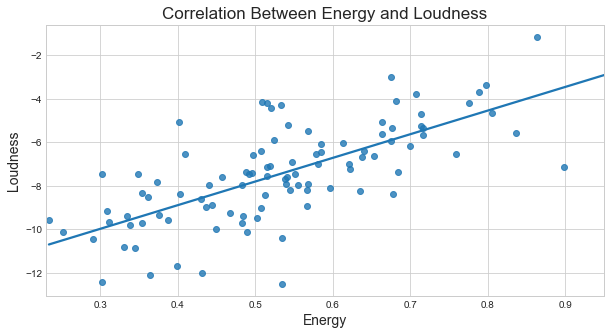

In [238]:
fig = plt.figure(figsize = (10, 5))

ax = sns.regplot(x = 'energy', y = 'loudness', data = df, ci = None)
ax.set_xlim(0.23, 0.95)
plt.title("Correlation Between Energy and Loudness", fontsize = 17)
plt.xlabel('Energy', fontsize = 14)
plt.ylabel('Loudness', fontsize = 14)

plt.show()

##  Danceability and Valence

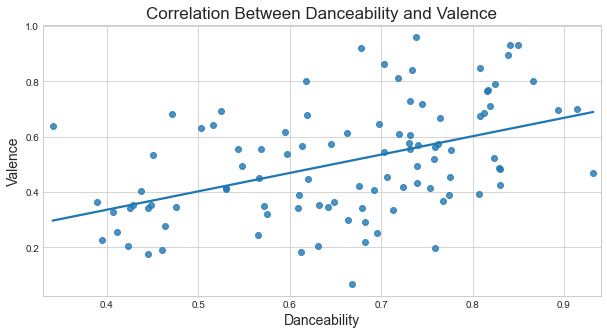

In [248]:
fig = plt.figure(figsize = (10, 5))

ax = sns.regplot(x = 'danceability', y = 'valence', data = df, ci = None)
ax.set_xlim(0.33, 0.94)
plt.title("Correlation Between Danceability and Valence", fontsize = 17)
plt.xlabel('Danceability', fontsize = 14)
plt.ylabel('Valence', fontsize = 14)

plt.show()

## Energy and Valence

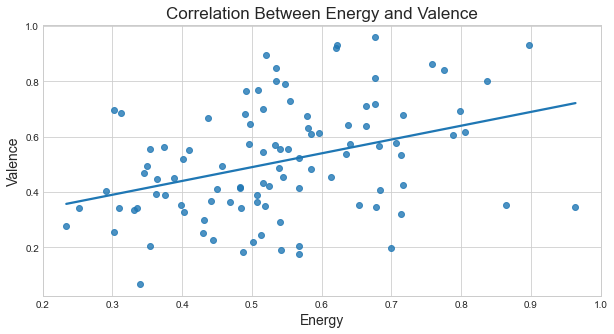

In [251]:
fig = plt.figure(figsize = (10, 5))

ax = sns.regplot(x = 'energy', y = 'valence', data = df, ci = None)
ax.set_xlim(0.2, 1.0)
plt.title("Correlation Between Energy and Valence", fontsize = 17)
plt.xlabel('Energy', fontsize = 14)
plt.ylabel('Valence', fontsize = 14)

plt.show()

## Energy and Liveness

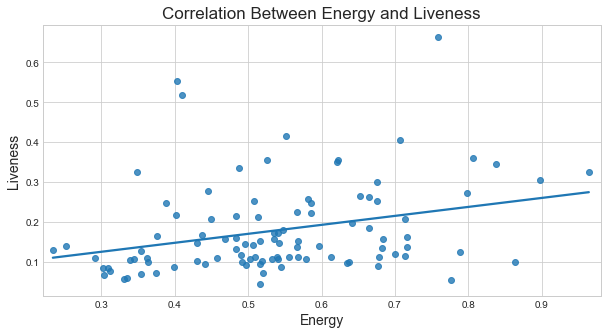

In [257]:
fig = plt.figure(figsize = (10, 5))

ax = sns.regplot(x = 'energy', y = 'liveness', data = df, ci = None)
ax.set_xlim(0.22, 0.98)
plt.title("Correlation Between Energy and Liveness", fontsize = 17)
plt.xlabel('Energy', fontsize = 14)
plt.ylabel('Liveness', fontsize = 14)

plt.show()

## Energy and Acousticness

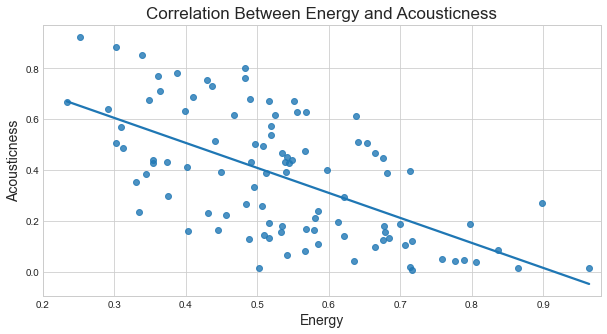

In [261]:
fig = plt.figure(figsize = (10, 5))
ax = sns.regplot(x = 'energy', y = 'acousticness', data = df, ci = None)
ax.set_xlim(0.2, 0.98)
plt.title("Correlation Between Energy and Acousticness", fontsize = 17)
plt.xlabel('Energy', fontsize = 14)
plt.ylabel('Acousticness', fontsize = 14)

plt.show()

## Radar chart of average audio features

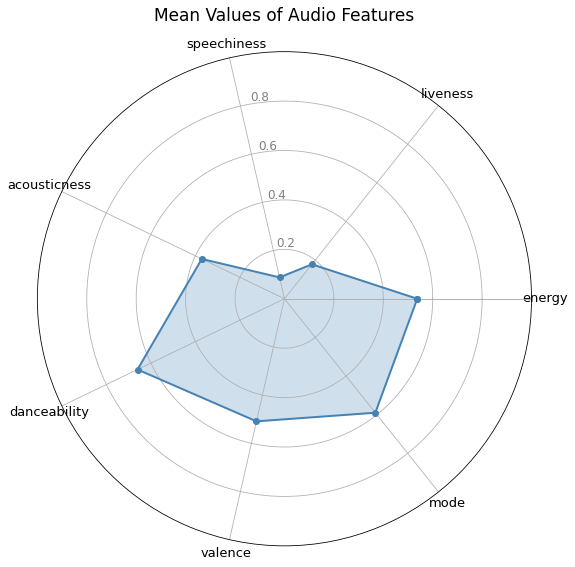

In [147]:
# Features we want to analyze
labels = ['energy', 'liveness', 'speechiness', 'acousticness', 'danceability', 'valence', 'mode']

# Averaging the data and creating the sections
stats = df[labels].mean().tolist()
angles = np.linspace(0, 2*np.pi, len(labels), endpoint = False)

# Plot closure
stats = np.concatenate((stats,[stats[0]]))
angles = np.concatenate((angles,[angles[0]]))

# Size of the figure
fig = plt.figure(figsize = (20,20))

# The internal figure
ax = fig.add_subplot(221, polar=True)
ax.plot(angles, stats, 'o-', linewidth = 2, color = 'steelblue')
ax.fill(angles, stats, alpha = 0.25, facecolor = 'steelblue')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)

# Internal level ticks
ax.set_rlabel_position(100)
plt.yticks([0.2 , 0.4 , 0.6 , 0.8  ], ['0.2','0.4', '0.6', '0.8'], color = 'grey', size = 12)
plt.ylim(0,1)

plt.title('Mean Values of Audio Features', fontsize = 17)
ax.grid(True)

## Radar chart of favorite song 'Wrong Places'

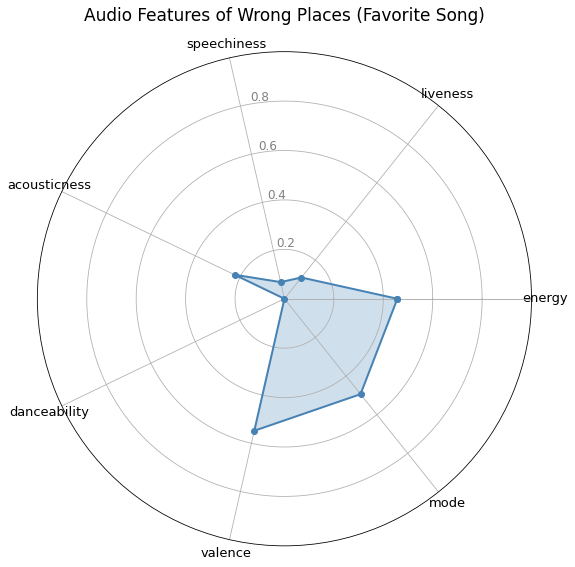

In [148]:
# Features we want to analyze
labels = ['energy', 'liveness', 'speechiness', 'acousticness', 'danceability', 'valence', 'mode']
# Choosing Wrong Places as the song to see
favorite_song = df.loc[0].reset_index()
# Selecting only the features is calculable and not the String objects like Artist 
fs = favorite_song[0].loc[2:12]

# Selecting the data values to match labels
stats = fs[(fs >=0) & (fs < 1)].tolist()
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

# Plot closure
stats = np.concatenate((stats,[stats[0]]))
angles = np.concatenate((angles,[angles[0]]))

# Size of the figure
fig = plt.figure(figsize = (20,20))

# The internal figure
ax = fig.add_subplot(221, polar = True)
ax.plot(angles, stats, 'o-', linewidth=2, color = 'steelblue')
ax.fill(angles, stats, alpha = 0.25, facecolor = 'steelblue')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)

# Internal level ticks
ax.set_rlabel_position(100)
plt.yticks([0.2 , 0.4 , 0.6 , 0.8  ], ['0.2','0.4', '0.6', '0.8'], color = 'grey', size = 12)
plt.ylim(0,1)

plt.title('Audio Features of Wrong Places (Favorite Song)', fontsize = 17)
ax.grid(True)

## 9. Import another data set. 
We have been looking at my 'Wrapped 2020' playlist so far, but now let us take a look at my streaming history and add it to our analysis. 

Theis a excel file of my streaming history which was downloaded from a zip supplied by Spotify after I requested a download of my personal data. 

## Objective.
to see the amount I listened to each song, the days I preferred it, as well as possible listening gaps where I did not feel like listening to music. 

In [453]:
df_sh = pd.read_excel('/Users/kellylam/Downloads/StreamingHistory0.xlsx')
df_sh.head()

,endTime,artistName,trackName,msPlayed,sPlayed
0,2020-01-13 23:41,Mahalia,What You Did (feat. Ella Mai),129248,129
1,2020-01-14 21:10,Mahalia,What You Did (feat. Ella Mai),83613,84
2,2020-01-14 21:14,Lucky Daye,Roll Some Mo,292884,293
3,2020-01-14 21:46,Kayla Rae,Practice,135332,135
4,2020-01-15 19:34,Jessie Reyez,Imported (with 6LACK),225040,225


In [313]:
df_sh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7726 entries, 0 to 7725
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     7726 non-null   object
 1   artistName  7726 non-null   object
 2   trackName   7726 non-null   object
 3   msPlayed    7726 non-null   int64 
 4   sPlayed     7726 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 301.9+ KB


**Since we already have seconds played, let us get rid of milliseconds played.**

In [454]:
df_sh.drop('msPlayed', axis = 1, inplace = True)
df_sh.head()

,endTime,artistName,trackName,sPlayed
0,2020-01-13 23:41,Mahalia,What You Did (feat. Ella Mai),129
1,2020-01-14 21:10,Mahalia,What You Did (feat. Ella Mai),84
2,2020-01-14 21:14,Lucky Daye,Roll Some Mo,293
3,2020-01-14 21:46,Kayla Rae,Practice,135
4,2020-01-15 19:34,Jessie Reyez,Imported (with 6LACK),225


**It looks like I played a lot of songs for a couple seconds before skipping. Let us disregard those since I was not really listening. Let us also get rid of values past 2020.**

In [455]:
df_sh = df_sh[(df_sh['endTime'] < '2021-01-01') & (df_sh['sPlayed'] >= 30)]
df_sh

,endTime,artistName,trackName,sPlayed
0,2020-01-13 23:41,Mahalia,What You Did (feat. Ella Mai),129
1,2020-01-14 21:10,Mahalia,What You Did (feat. Ella Mai),84
2,2020-01-14 21:14,Lucky Daye,Roll Some Mo,293
3,2020-01-14 21:46,Kayla Rae,Practice,135
4,2020-01-15 19:34,Jessie Reyez,Imported (with 6LACK),225
...,...,...,...,...
7546,2020-12-30 21:02,Kayla Rae,Practice,144
7547,2020-12-30 21:06,Dreamville,Self Love (with Ari Lennox & Bas feat. Baby Rose),223
7549,2020-12-31 20:40,KAMAUU,Far Rockaway,31
7550,2020-12-31 20:42,Sweater Beats,Hey Ya,86


**Now we will take a look at the distribution of the days I have listened to muisc on Spotify**

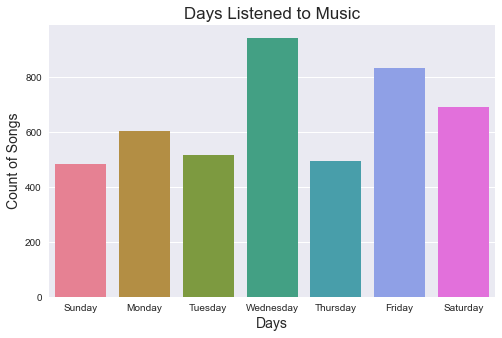

In [533]:
dates = pd.to_datetime(df_sh['endTime'])
df_sh['weekdays'] = dates.dt.day_name()

fig = plt.figure(figsize = (8,5))
sns.countplot(x = weekdays , data = weekdays, 
              order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], 
              palette = 'husl')
plt.title('Days Listened to Music', fontsize = 17)
plt.xlabel('Days', fontsize = 14)
plt.ylabel('Count of Songs', fontsize = 14)

plt.show()

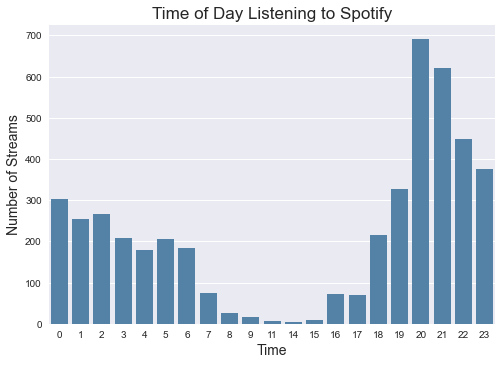

In [597]:
df_sh['hour_time'] = dates.dt.hour

sns.countplot(x = hour_time, data = hour_time, color = 'steelblue')

plt.title('Time of Day Listening to Spotify', fontsize = 17)
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Number of Streams', fontsize = 14)

plt.show()

**Judging from the graph above, it seems like there are erroneous values. Assuming that Spotify uses military time, it suggests that I am awake at 6 AM listening to music and never listen to music around 1 PM which is suspicious because 1 PM is my standard commute time.**

**Let us try to reformat these times.**

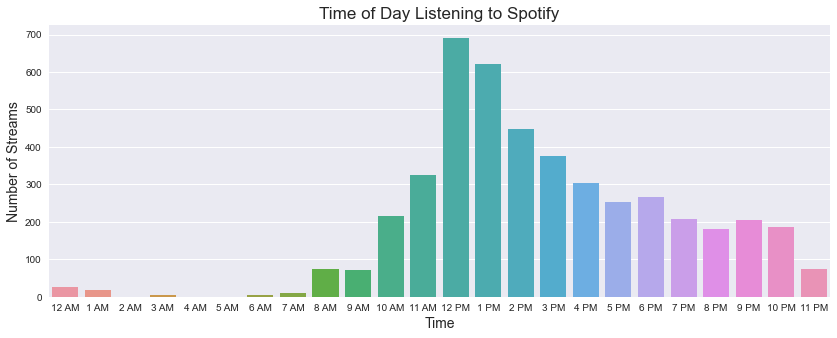

In [599]:
fig = plt.figure(figsize = (14,5))

time_mapping = {0: '4 PM', 1: '5 PM', 2: '6 PM', 3: '7 PM', 4: '8 PM', 5: '9 PM', 6: '10 PM', 7: '11 PM', 8: '12 AM', 9: '1 AM', 10: '2 AM', 11: '3 AM', 12: '4 AM', 13: '5 AM', 14: '6 AM', 15: '7 AM', 16: '8 AM', 17: '9 AM', 18:'10 AM', 19: '11 AM', 20: '12 PM', 21: '1 PM', 22: '2 PM', 23: '3 PM'}
df_sh['hour_time'] = df_sh['hour_time'].map(time_mapping)
sns.countplot(x = 'hour_time', data = df_sh, order = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM'])
plt.title('Time of Day Listening to Spotify', fontsize = 17)
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Number of Streams', fontsize = 14)

plt.show()

**Now the above graph makes more sense. I usually drive and listen to music and I do so in the later half of noon. Sometimes I am up at midnight listening to music while getting work done, but rarely ever.**

**I suspect the 3 AM streaming sessions are not an outlier because there was a period of time during 2020 where I dedicated extra time during the night to study.**

## Distribution of streaming for each day of the week.

**I initially mapped the time in a AM/PM format. Now that we want to see a ridge plot of the weekday and streaming time, let us convert the corrected hours back into military time (24 hours).**

In [619]:
def convert24(str1): 
    # if midnight
    if str1[-2:] == "AM" and str1[:2] == "12": 
        return 0
    # if AM
    elif str1[-2:] == "AM": 
        return int(str1[:-2])
    # if noon   
    elif str1[-2:] == "PM" and str1[:2] == "12": 
        return int(str1[:-2])  
    else: 
        # add 12 to hours and remove PM 
        return int(str1[:2]) + 12

# temp var
converted_hrs = []
for i in df_sh['hour_time']:
    converted_hrs.append(convert24(i))

df_sh['hour_time'] = converted_hrs

0       15
1       13
2       13
3       13
4       11
        ..
7546    13
7547    13
7549    12
7550    12
7551    12
Name: hour_time, Length: 4563, dtype: int64

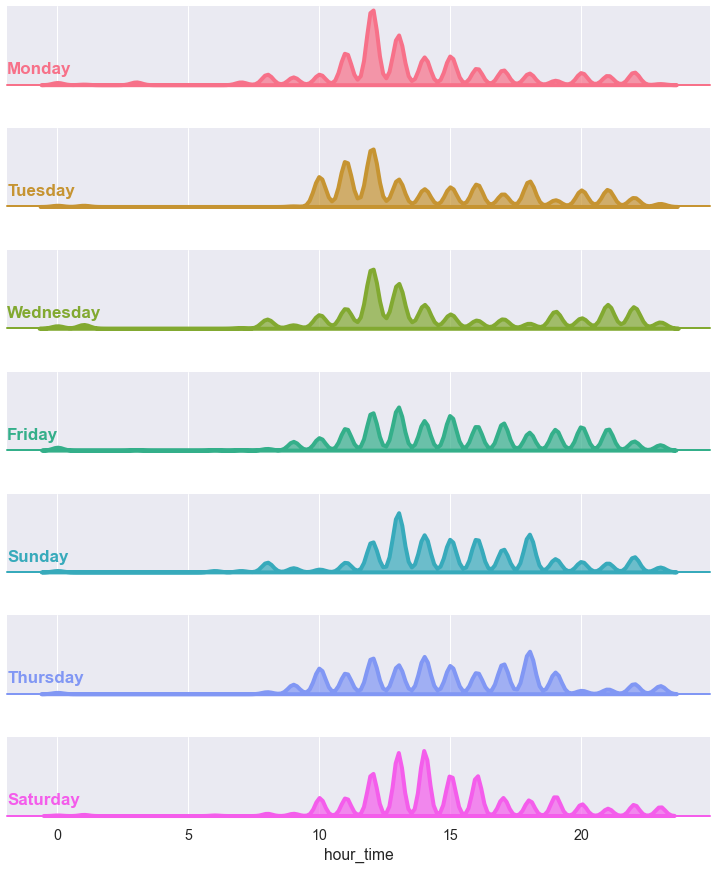

In [640]:
# Initialize the FacetGrid
rp = sns.FacetGrid(df_sh, row = 'weekdays', hue = 'weekdays', aspect = 6, height = 1.8, palette = 'husl') 

# Draw the densities
rp.map(sns.kdeplot, 'hour_time', clip_on = False, fill = True, alpha = 0.7, lw = 4, bw_adjust = .2) 
rp.map(plt.axhline, y = 0, lw = 2, clip_on = False) 

# Function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontsize = 17, fontweight = "bold", color = color,
            ha = "left", va = "center", transform = ax.transAxes)

rp.map(label, 'hour_time')

# Remove axes details and resize font to see clearly
rp.set_titles("")
rp.set(yticks = [])
sns.set(font_scale = 1.3)
rp.despine(bottom = True, left = True)

In [650]:
# df_gb = df_sh.groupby(['trackName'])['sPlayed'].agg('sum').sort_values(ascending=False)
# df_gb

trackName
Wrong Places (from Songland)            13121
Call                                    11126
Buying Time                              9877
Shoulda (feat. Babyface)                 9211
Love Affair                              9135
                                        ...  
Caught Up (feat. Khalid)                   31
Just Get Here (feat. Wale & VanJess)       31
be by my side                              31
Deck the Halls - Interlude                 30
Frankenstein                               30
Name: sPlayed, Length: 1087, dtype: int64